## Modelling the SARIMA

Configuring the SARIMA model based on the parameters found by looking at the ACF, PACF and seasonal_decompose plots.

(p, d, q) x (P, D, Q )S

(0, 1, 1) x (0, 1, 1)7



In [40]:
import pandas as pd
daily_visits_websites1 = pd.read_csv('/Users/dgrimm1/Documents/analytics-traffic-forecast/data/ivw_spring_visits_latest.csv', delimiter=',', index_col='Tag', parse_dates=True)
daily_visits_bildde = daily_visits_websites1[['BILDde']]
#daily_visits_bildde_sorted_visits = daily_visits_bildde.sort_values(by='BILDde', ascending=True)
daily_visits_bildde_sorted = daily_visits_bildde.sort_values(by='Tag', ascending=True)
ts = daily_visits_bildde_sorted['BILDde'].loc['2014-03-31':'2020-05-31']

In [41]:
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results = mod.fit()
print(results.summary().tables[1])

/Users/dgrimm1/.pyenv/versions/3.8.7/envs/tools/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dgrimm1/.pyenv/versions/3.8.7/envs/tools/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3987      0.022    -17.872      0.000      -0.442      -0.355
ma.S.L7       -0.9668      0.011    -89.364      0.000      -0.988      -0.946
sigma2      2.933e+11   6.02e-15   4.87e+25      0.000    2.93e+11    2.93e+11


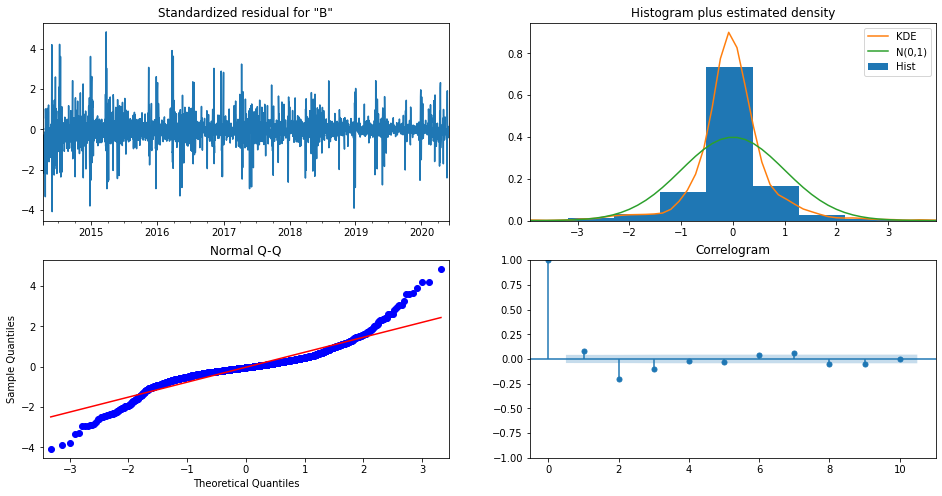

In [42]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

By looking at the residual error on the top left plot, one can see that it fluctuates around a mean of zero. The top right plot shows that the density seems not to be perfectly normal distributed, since within the Normal Q-Q plot, the blue line does not fit very well with the red line, which in turn could mean that the distribution is skewed. 

The Correlogram on the bottom right corner depicts that the residual errors are not autocorrelated. Since there is no pattern in the residual errors that could further explain the model any better, there seems to be no autocorrelation in it.

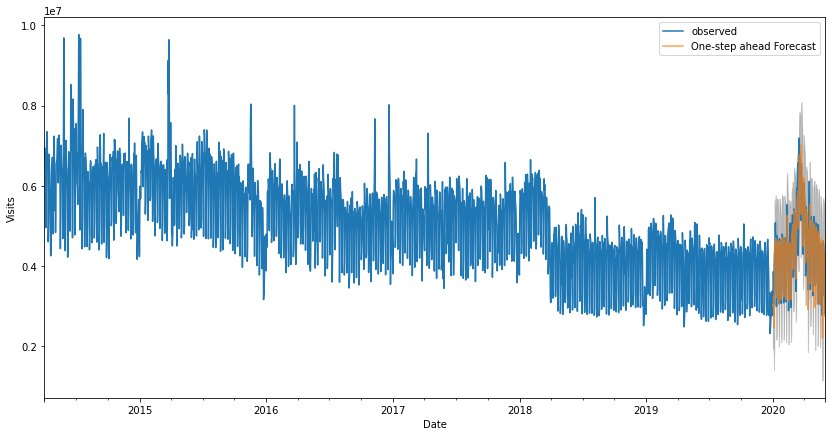

In [43]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visits')
plt.legend()
plt.show()

Let's check for the model's perfomance using various methods such as Mean Error (ME), Mean Squared Error (MSE), Root Mean Squared Error (RMSE) as well as R2

In [44]:
y_forecasted = pred.predicted_mean
y_truth = ts['2020-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 127930207122.88


In [45]:
import numpy as np
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 357673.32


In [46]:
r2 = r2_score(y_truth, y_forecasted)
print('R2 of our forecasts is {}'.format(round(r2, 2)))

R2 of our forecasts is 0.87


By checking MSE and RMSE, one can see that the numbers are pretty high and difficult to interpret. In order to get a better picture, I'll use R-squared meanwhile.

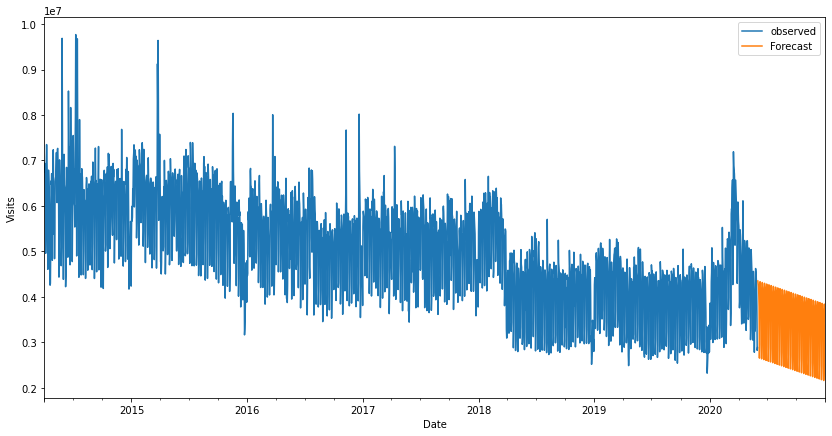

In [47]:
pred_uc = results.get_forecast(steps=214)
pred_ci = pred_uc.conf_int()
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Visits')
plt.legend()
plt.show()

By looking at the graph, the forecast doesnt look very promising and trustworthy. One can see that there is a downward trend in the series but the steepness of the forecast does not fit the overall trend. This could mean that we should tweak the parameters again in order to receive a better forecast. One way of doing so for SARIMAX could be a grid search to find the best parameter combinations using either the Akaike information (AIC) or BIC (Bayesian information) criterion. What these criterions do is selecting the best parameter combinations by finding the biggest amount of variation taking into consideration the fewest amount of independent variable using Maximum Likelihood Estimation to calculate it. So, the more variables the higher the penalization. This is done to prevent overfitting. I decided to go for AIC


In [48]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]


In [49]:
import warnings
warnings.filterwarnings("ignore")
aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,order=param,seasonal_order=param_seasonal, enforce_stationarity=True,enforce_invertibility=True)
            results = mod.fit()
            aic.append([param, param_seasonal, results.aic])
            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:76119.88741787232
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:74551.60955147425
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:66129.22401612526
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:65720.98872301515
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:66360.4891915488
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:65746.22650099752
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:65891.39485476623
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:65645.89897116268
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:74457.2748233958
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:74077.3229999401
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:65492.18347139007
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:64951.53358755428
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:73842.4733272209
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:73835.76091516603
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:65188.913875236234
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:64915.08268945482
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:67824.51086086521
ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:66980.25262904135
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC:65857.70666577

In [50]:
    # Convert into dataframe
    aic_df = pd.DataFrame(aic, columns=['pdq', 'pdqs', 'aic'])
    # Sort and return top 5 combinations
    aic_df = aic_df.sort_values(by=['aic'],ascending=True)[0:3]
    aic_df

,pdq,pdqs,aic
47,"(1, 0, 1)","(1, 1, 1, 7)",64495.715431
43,"(1, 0, 1)","(0, 1, 1, 7)",64499.038769
39,"(1, 0, 0)","(1, 1, 1, 7)",64516.191199


Let's try modelling our SARIMA again using the best AIC parameter combination

In [51]:
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8419      0.018     48.043      0.000       0.808       0.876
ma.L1         -0.2654      0.033     -8.009      0.000      -0.330      -0.200
ar.S.L7        0.0722      0.026      2.826      0.005       0.022       0.122
ma.S.L7       -0.9331      0.015    -61.605      0.000      -0.963      -0.903
sigma2      2.463e+11   2.91e-14   8.48e+24      0.000    2.46e+11    2.46e+11


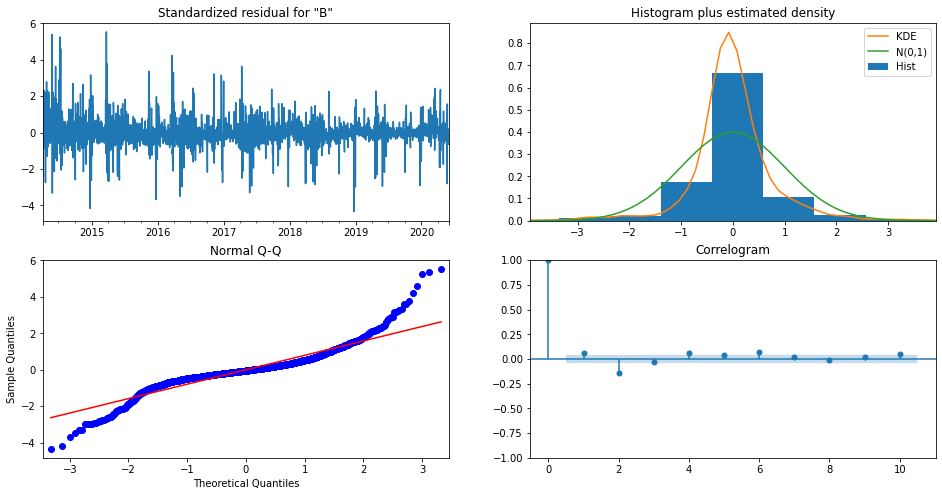

In [52]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

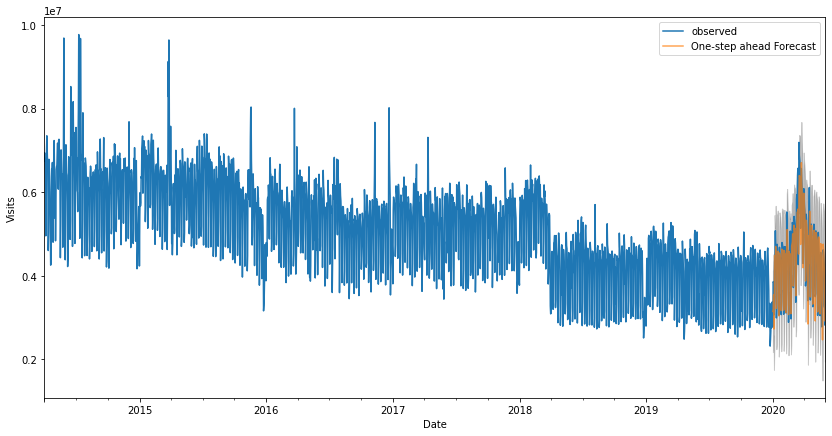

In [53]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visits')
plt.legend()
plt.show()

In [54]:
y_forecasted = pred.predicted_mean
y_truth = ts['2020-01-01':]


In [55]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(np.mean(y_forecasted - y_truth) ** 2)
me = np.median(y_truth - y_forecasted)
#mse = np.square(np.subtract(y_forecasted, y_truth)).mean()
mse = mean_squared_error(y_truth, y_forecasted)
r2 = r2_score(y_truth, y_forecasted)
print("me: " + str(round(me, 4)) + ", rmse: " + str(round(rmse, 4)) + ", mse: " + str(round(mse, 4)) + ", r2: " + str(round(r2, 4)))

me: 38261.9011, rmse: 78069.1559, mse: 135075146633.4973, r2: 0.8589


When looking at the performance metrics, this parameter combination seems to be better than the previous ones with a higher value for r2

#### First Version results:

r2: 0.87, mse: 127930207122.88


#### Latest Version results using grid search and AIC:
r2: 0.8589, mse: 135075146633.4973

Let's see if the forecast looks more promising this time

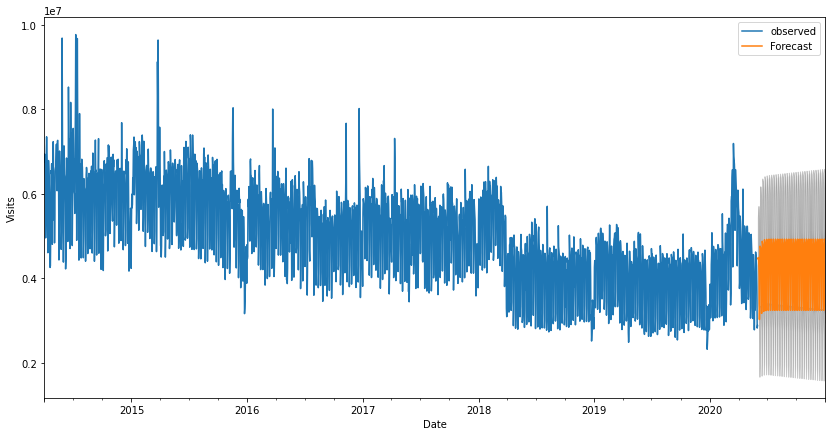

In [56]:
pred_uc = results.get_forecast(steps=214)
pred_ci = pred_uc.conf_int()
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Visits')
plt.legend()
plt.show()

The forecast looks better than the first model parameter combination although the Covid-19 increase does have an overall positive impact on the trend. This could be the case, because of the forecast model that gives values that are closer to the forecast more weight than values that lay further back in history. It still looks promising and I'm excited how good a LSTM model can predict future values.

## Modelling the LSTM

In [57]:
lstm = ts.to_frame()

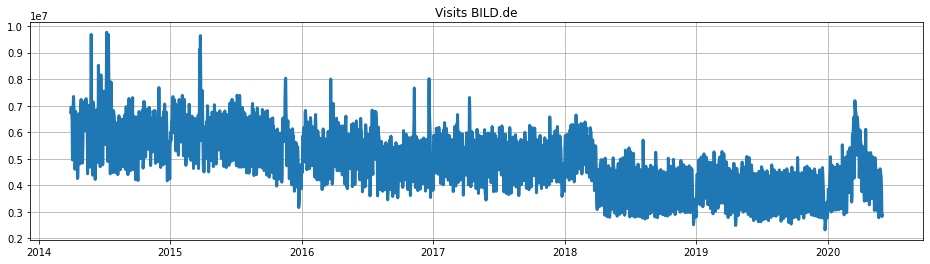

In [58]:
fig, ax1 = plt.subplots(figsize=(16, 4))
#ax1.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.title("Visits BILD.de")
plt.plot(lstm, linewidth=3.0)
plt.grid()
plt.show()

LSTM stands for Long Short Term Memory. It is a special form of an RNN. LSTM is considered to be a good model when it comes to predict a Time Series. Due to it's capability to take past events into consideration and only store the relevant information over time to use this to predict future values, it is highly appreciated to experiment with it. 
First of all, I will import the required libraries and split the dataset into train (80% of the data) and test (20%). Then I need to transform and shape the data in order to fit it into the format required by an LSTM. Part of that  is done by using the MinMaxScaler function to make it better readable for the algorithm to work with the scaled data ranging between 0 and 1. Besides, the data needs to be converted into numpy arrays and reshaped to be consumable for the LSTM.


In [59]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation

In [60]:

# Setting neurons for the LSTM
lstm_neuron_number = 100

# spliting the dataset for train and test | 80% : 20% 
npdataset = lstm.values
training_data_length = math.ceil(len(npdataset) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1 for better maschine learning readability
mmscaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = mmscaler.fit_transform(npdataset)

# Create a scaled training data set
train_data = scaled_data[0:training_data_length, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
trainingdatasize = len(train_data)
for i in range(lstm_neuron_number, trainingdatasize):
    x_train.append(
        train_data[i - lstm_neuron_number : i, 0]
    )  
    y_train.append(train_data[i, 0])  

# Create numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshaping the data for the LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("x_tain.shape: " + str(x_train.shape) + " | y_tain.shape: " + str(y_train.shape))



x_tain.shape: (1704, 100, 1) | y_tain.shape: (1704,)


Now, it's time to set the hyper parameter for the LSTM model. First of all, I will set the parameter more or less random as a starting point. This includes to set the right amount of neurons, epochs and the batch size, which are crucial for the model and need to be tweaked to get the best results. 

The batch size is the number of sequences/samples looked at at the same time during the learning phase. It's the limitation of the batches shown to the network before a weight update can be performed. This same limitation is then imposed when making predictions with the fit model. A batch size of 64 is supposed to be good fit for a starting point. Nonetheless, the selected batch size could contain any number as long it is dividable by 8. It's then used to control how many predictions you must make at a time for prediction. The fine-tuning and setting of the parameter should be based on the performance observation.

The Epochs are the number of iterations the algroithm goes through the training dataset for learning purposes. The model parameters have the opportunity to update with each epoch then. It goes over each batch of samples and each has the specified “batch size” number of samples to go through. The number of epochs is usually large, so that the learning alogrithm can go over it again and again in order to minimize the error from the model.

The number of neurons determine the capability of the network to learn. The underlying assumption is that the more neurons the network has, the more of the structure of the network will be able to learn. But takes far longer and is more likely to overfit the training data.

In [62]:
# Setting the Hyperparameter of the LSTM
epochs = 90; 
batch_size = 15; 
lstm_neuron_number = 100



Using a Sequential model is of good use when you have a plain stack of layers and each layer has only one input tensor and an output tensor. A Sequential model has no weights unless it sees some input data. If one predefines the input_shape then it already has weights even before seeing the data and always has a defined output shape. One can stack layers, but I will start off with one layer. Furthermore, I set the return_sequence to false and specify the training configuration (optimizer, loss). 

I'll start with the "adam" optimizer to see how well it'll increase the accuracy of the model. For the loss function, I will choose the Mean Squared Error to estimate the loss of the model so that the weights can be updated to reduce the loss on the next evaluation. 

In [64]:
# Configure and compile the neural network model
model = Sequential()
model.add(LSTM(lstm_neuron_number, activation='relu', return_sequences=False, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Create the test data set
test_data = scaled_data[training_data_length - lstm_neuron_number :, :]

# Create the data sets x_test and y_test
x_test = []
y_test = npdataset[training_data_length:, :]
for i in range(lstm_neuron_number, len(test_data)):
    x_test.append(test_data[i - lstm_neuron_number : i, 0])

In [65]:
# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/90
114/114 [==============================] - 6s 37ms/step - loss: 0.0473
Epoch 2/90
114/114 [==============================] - 4s 39ms/step - loss: 0.0132
Epoch 3/90
114/114 [==============================] - 4s 36ms/step - loss: 0.0131
Epoch 4/90
114/114 [==============================] - 5s 39ms/step - loss: 0.0127
Epoch 5/90
114/114 [==============================] - 5s 40ms/step - loss: 0.0122
Epoch 6/90
114/114 [==============================] - 5s 41ms/step - loss: 0.0124
Epoch 7/90
114/114 [==============================] - 4s 37ms/step - loss: 0.0116
Epoch 8/90
114/114 [==============================] - 4s 38ms/step - loss: 0.0118
Epoch 9/90
114/114 [==============================] - 4s 37ms/step - loss: 0.0108
Epoch 10/90
114/114 [==============================] - 4s 38ms/step - loss: 0.0119
Epoch 11/90
114/114 [==============================] - 4s 37ms/step - loss: 0.0109
Epoch 12/90
114/114 [==============================] - 4s 37ms/step - loss: 0.0098
Epoch 13/90
1

In [66]:
# Single Step
# Reshape the data, so that we get an array with multiple test datasets
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the predicted values
predictions = model.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)



Now, I will evaluate the model's performance using the rmse, mse and r2 to do so. 

In [68]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
me = np.median(y_test - predictions)
mse = np.square(np.subtract(predictions, y_test)).mean()
r2 = r2_score(y_test, predictions)


print("me: " + str(round(me, 4)) + ", rmse: " + str(round(rmse, 4)) + ", mse: " + str(round(mse, 4)) + ", r2: " + str(round(r2, 4)))

me: -48790.25, rmse: 64974.6433, mse: 122577323712.2494, r2: 0.8377


Since the values are too high for rmse and mse interpretation, I will use the R2 again. The R-squared result looks  good because a value close to 1 would be a perfect result.

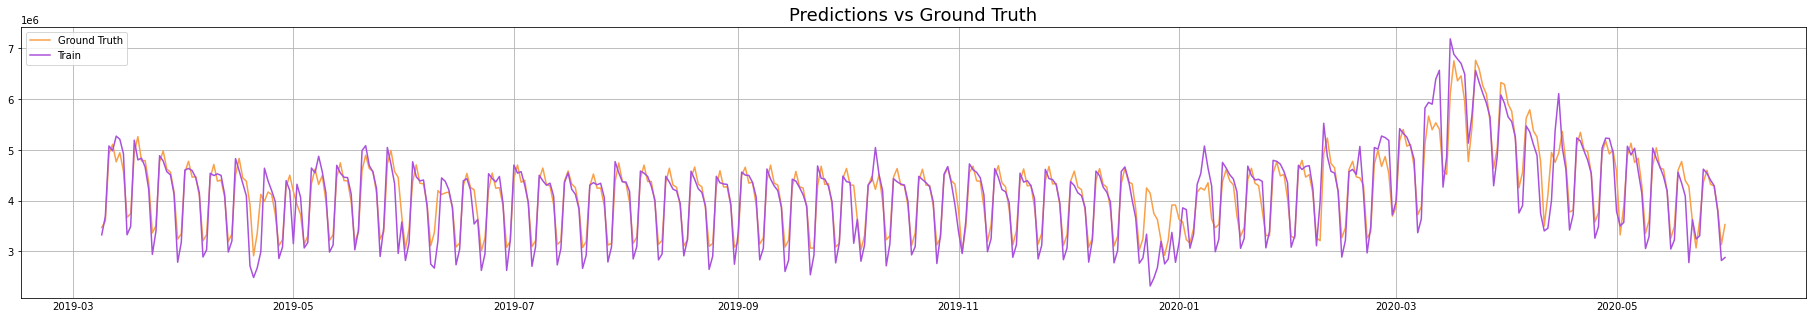

In [69]:
# Visualize the data
train = lstm[:training_data_length]
valid = lstm[training_data_length:]
valid.insert(1, "Predictions", predictions, True)
fig, ax1 = plt.subplots(figsize=(32, 5), sharex=True)
yt = train[["BILDde"]]
yv = valid[["BILDde", "Predictions"]]
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("Predictions vs Ground Truth", fontsize=18)
plt.plot(yv["Predictions"], color="#F9A048")
plt.plot(yv["BILDde"], color="#A951DC")
plt.legend(["Ground Truth", "Train"], loc="upper left")
plt.grid()
plt.show()

When looking at the graph, it seems that there is a good fit between the actual values and the data from the training set. Let's have a look at the loss model over the epochs.

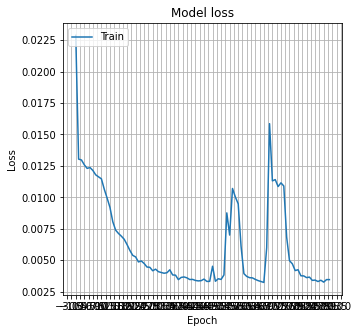

In [70]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

Even after the first epoch, a huge drop can be seen in the plot. Moreover, at around the 50th epoch another drop can be seen in the plot as well. Now, we will focus on the rolling forecast.

In [71]:
# Settings and Model Labels
rolling_forecast_range = 214
titletext = "Forecast Chart Model A"
ms = [
    ["epochs", epochs],
    ["batch_size", batch_size],
    ["lstm_neuron_number", lstm_neuron_number],
    ["rolling_forecast_range", rolling_forecast_range],
    ["layers", "LSTM, DENSE(1)"],
]
settings_text = ""
lms = len(ms)
for i in range(0, lms):
    settings_text += ms[i][0] + ": " + str(ms[i][1])
    if i < lms - 1:
        settings_text = settings_text + ",  "

# Making a Multi-Step Prediction
new_df = lstm.filter(["BILDde"])
for i in range(0, rolling_forecast_range):
    last_values = new_df[-lstm_neuron_number:].values
    last_values_scaled = mmscaler.transform(last_values)
    X_input = []
    X_input.append(last_values_scaled)
    X_input = np.array(X_input)
    X_test = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))
    pred_value = model.predict(X_input)
    pred_value_unscaled = mmscaler.inverse_transform(pred_value)
    pred_value_f = round(pred_value_unscaled[0, 0], 4)
    next_index = new_df.iloc[[-1]].index.values + 1
    new_df = new_df.append(pd.DataFrame({"BILDde": pred_value_f}, index=next_index))
    new_df_length = new_df.size
forecast = new_df[new_df_length - rolling_forecast_range : new_df_length].rename(
    columns={"BILDde": "Forecast"}
)

In [72]:
n_forecast = forecast.values.shape[0]

In [73]:
import pandas as pd
from datetime import datetime
import numpy as np
date_rng = pd.date_range(start='06/01/2020', periods = n_forecast, freq='D')
df1 = pd.DataFrame(date_rng, columns=['Tag'])
df1['BILDde_Prediction'] = forecast.values
df3 = df1.set_index('Tag')

frames = [yt, yv, df3]
result = pd.concat(frames)

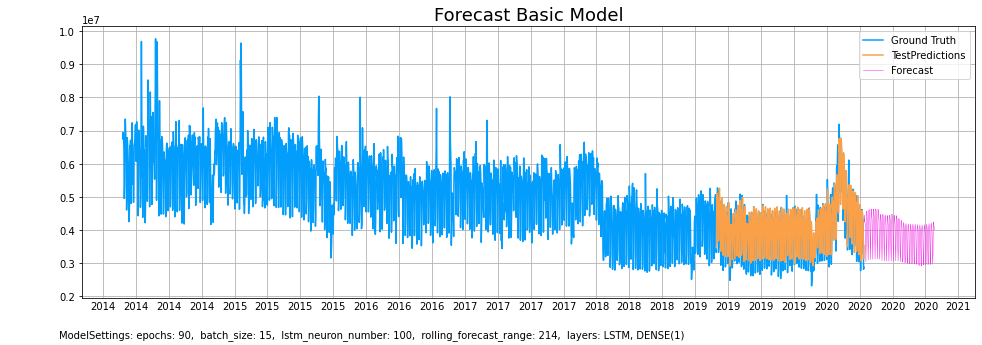

In [74]:
# Visualize the data
yt = train[["BILDde"]]
yv = valid[["BILDde", "Predictions"]]

fig, ax1 = plt.subplots(figsize=(16, 5), sharex=True)
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
ax1.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.title('Forecast Basic Model', fontsize=18)
plt.plot(result["BILDde"], color="#039dfc", linewidth=1.5)
plt.plot(result["Predictions"], color="#F9A048", linewidth=1.5)
plt.plot(result['BILDde_Prediction'], color="#F332E6", linewidth=0.5)
plt.legend(["Ground Truth", "TestPredictions", "Forecast"], loc="upper right")
ax1.annotate('ModelSettings: ' + settings_text, xy=(0.06, .015),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10)
plt.grid()
plt.show()




When looking at the Forecast for 214 steps ahead, it looks very promising that the prediction is not too far off the expected value which would probably range around the values before the Covid-19 pandamic started. Now, I will change the amount of neuron and batch size and see if it turns out to be worth changing the hyper parameter.

In [75]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation

In [76]:

# Setting neurons for the LSTM
lstm_neuron_number = 150

# spliting the dataset for train and test | 80% : 20% 
npdataset = lstm.values
training_data_length = math.ceil(len(npdataset) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = mmscaler.fit_transform(npdataset)

# Create a scaled training data set
train_data = scaled_data[0:training_data_length, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
trainingdatasize = len(train_data)
for i in range(lstm_neuron_number, trainingdatasize):
    x_train.append(
        train_data[i - lstm_neuron_number : i, 0]
    )  
    y_train.append(train_data[i, 0])  

# Create numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshaping the data for the LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("x_tain.shape: " + str(x_train.shape) + " | y_tain.shape: " + str(y_train.shape))



x_tain.shape: (1654, 150, 1) | y_tain.shape: (1654,)


In [77]:
# Setting the Hyperparameter of the LSTM
epochs = 90; 
batch_size = 45; 
lstm_neuron_number = 150

In [78]:
# Configure and compile the neural network model
model = Sequential()
model.add(LSTM(lstm_neuron_number, activation='relu', return_sequences=False, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Create the test data set
test_data = scaled_data[training_data_length - lstm_neuron_number :, :]

# Create the data sets x_test and y_test
x_test = []
y_test = npdataset[training_data_length:, :]
for i in range(lstm_neuron_number, len(test_data)):
    x_test.append(test_data[i - lstm_neuron_number : i, 0])

In [79]:
# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/90
37/37 [==============================] - 6s 125ms/step - loss: 0.0614
Epoch 2/90
37/37 [==============================] - 5s 125ms/step - loss: 0.0133
Epoch 3/90
37/37 [==============================] - 5s 124ms/step - loss: 0.0129
Epoch 4/90
37/37 [==============================] - 5s 140ms/step - loss: 0.0116
Epoch 5/90
37/37 [==============================] - 5s 126ms/step - loss: 0.0126
Epoch 6/90
37/37 [==============================] - 5s 137ms/step - loss: 0.0124
Epoch 7/90
37/37 [==============================] - 5s 129ms/step - loss: 0.0118
Epoch 8/90
37/37 [==============================] - 5s 140ms/step - loss: 0.0116
Epoch 9/90
37/37 [==============================] - 5s 139ms/step - loss: 0.0122
Epoch 10/90
37/37 [==============================] - 5s 141ms/step - loss: 0.0121
Epoch 11/90
37/37 [==============================] - 5s 139ms/step - loss: 0.0123
Epoch 12/90
37/37 [==============================] - 5s 134ms/step - loss: 0.0124
Epoch 13/90
37/37 [======

In [80]:
# Single Step
# Reshape the data, so that we get an array with multiple test datasets
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the predicted values
predictions = model.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)


In [81]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
me = np.median(y_test - predictions)
mse = np.square(np.subtract(predictions, y_test)).mean()
r2 = r2_score(y_test, predictions)

print("me: " + str(round(me, 4)) + ", rmse: " + str(round(rmse, 4)) + ", mse: " + str(round(mse, 4)) + ", r2: " + str(round(r2, 4)))

me: -30185.5, rmse: 45106.0011, mse: 107281728640.9389, r2: 0.858


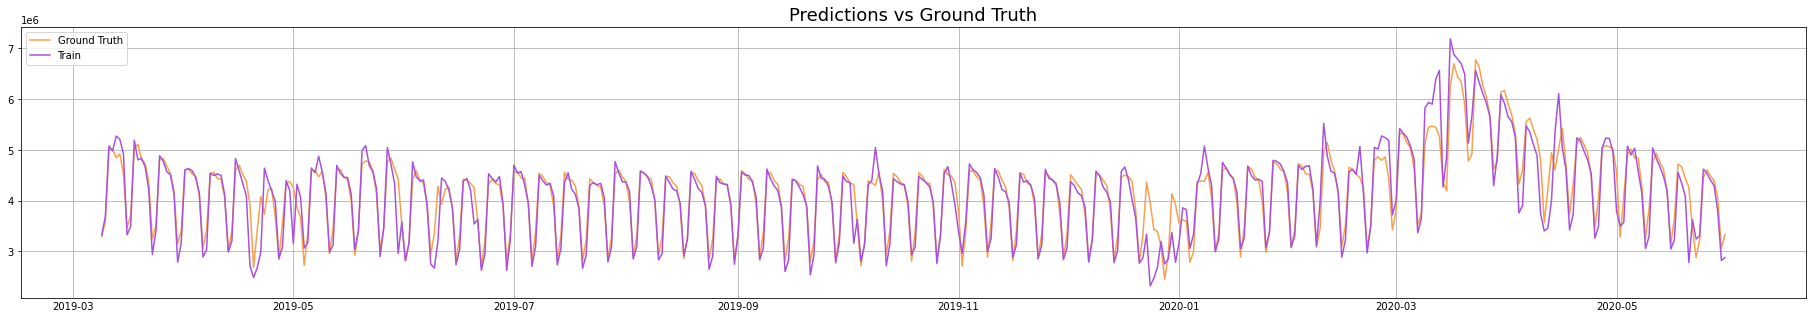

In [82]:
# Visualize the data
train = lstm[:training_data_length]
valid = lstm[training_data_length:]
valid.insert(1, "Predictions", predictions, True)
fig, ax1 = plt.subplots(figsize=(32, 5), sharex=True)
yt = train[["BILDde"]]
yv = valid[["BILDde", "Predictions"]]
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("Predictions vs Ground Truth", fontsize=18)
plt.plot(yv["Predictions"], color="#F9A048")
plt.plot(yv["BILDde"], color="#A951DC")
plt.legend(["Ground Truth", "Train"], loc="upper left")
plt.grid()
plt.show()

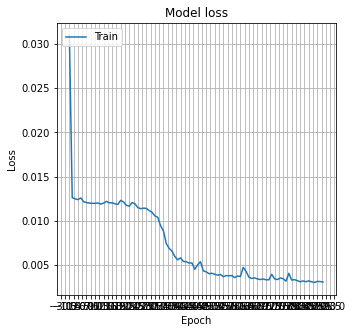

In [83]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [84]:
# Settings and Model Labels
rolling_forecast_range = 214
titletext = "Forecast Chart Model A"
ms = [
    ["epochs", epochs],
    ["batch_size", batch_size],
    ["lstm_neuron_number", lstm_neuron_number],
    ["rolling_forecast_range", rolling_forecast_range],
    ["layers", "LSTM, DENSE(1)"],
]
settings_text = ""
lms = len(ms)
for i in range(0, lms):
    settings_text += ms[i][0] + ": " + str(ms[i][1])
    if i < lms - 1:
        settings_text = settings_text + ",  "

# Making a Multi-Step Prediction
new_df = lstm.filter(["BILDde"])
for i in range(0, rolling_forecast_range):
    last_values = new_df[-lstm_neuron_number:].values
    last_values_scaled = mmscaler.transform(last_values)
    X_input = []
    X_input.append(last_values_scaled)
    X_input = np.array(X_input)
    X_test = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))
    pred_value = model.predict(X_input)
    pred_value_unscaled = mmscaler.inverse_transform(pred_value)
    pred_value_f = round(pred_value_unscaled[0, 0], 4)
    next_index = new_df.iloc[[-1]].index.values + 1
    new_df = new_df.append(pd.DataFrame({"BILDde": pred_value_f}, index=next_index))
    new_df_length = new_df.size
forecast = new_df[new_df_length - rolling_forecast_range : new_df_length].rename(
    columns={"BILDde": "Forecast"}
)

In [85]:
n_forecast = forecast.values.shape[0]

In [86]:
import pandas as pd
from datetime import datetime
import numpy as np
date_rng = pd.date_range(start='06/01/2020', periods = n_forecast, freq='D')
df1 = pd.DataFrame(date_rng, columns=['Tag'])
df1['BILDde_Prediction'] = forecast.values
df3 = df1.set_index('Tag')

frames = [yt, yv, df3]
result = pd.concat(frames)

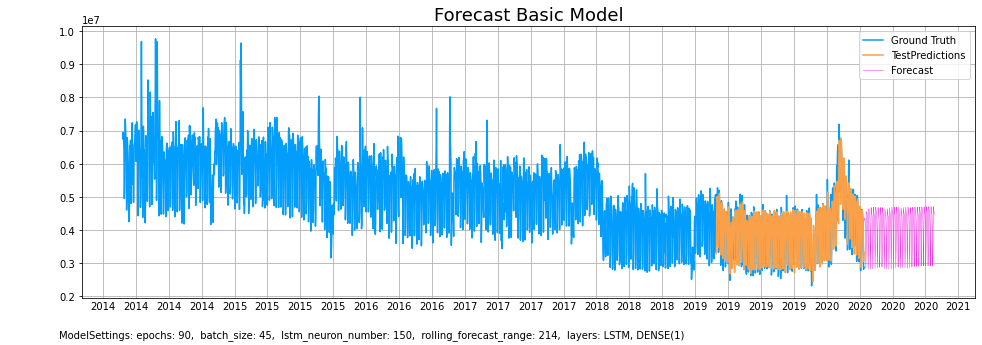

In [87]:
# Visualize the data
yt = train[["BILDde"]]
yv = valid[["BILDde", "Predictions"]]

fig, ax1 = plt.subplots(figsize=(16, 5), sharex=True)
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
ax1.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.title('Forecast Basic Model', fontsize=18)
plt.plot(result["BILDde"], color="#039dfc", linewidth=1.5)
plt.plot(result["Predictions"], color="#F9A048", linewidth=1.5)
plt.plot(result['BILDde_Prediction'], color="#F332E6", linewidth=0.5)
plt.legend(["Ground Truth", "TestPredictions", "Forecast"], loc="upper right")
ax1.annotate('ModelSettings: ' + settings_text, xy=(0.06, .015),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10)
plt.grid()
plt.show()



This forecast looks very promising and even better than the first hyper parameter combination predicition.